<a href="https://colab.research.google.com/github/PeanutButtermitKase/MolecularModelingTools/blob/main/RL_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 10%|█         | 513/5000 [00:07<01:07, 66.75it/s]

Episode 500: Avg Reward (last 500): -200.00, Epsilon: 0.606


 20%|██        | 1017/5000 [00:15<01:04, 62.01it/s]

Episode 1000: Avg Reward (last 500): -199.96, Epsilon: 0.368


 30%|███       | 1508/5000 [00:23<01:06, 52.82it/s]

Episode 1500: Avg Reward (last 500): -197.74, Epsilon: 0.223


 40%|████      | 2017/5000 [00:31<00:53, 56.06it/s]

Episode 2000: Avg Reward (last 500): -195.62, Epsilon: 0.135


 50%|█████     | 2511/5000 [00:39<00:37, 66.78it/s]

Episode 2500: Avg Reward (last 500): -194.92, Epsilon: 0.082


 60%|██████    | 3013/5000 [00:46<00:28, 69.61it/s]

Episode 3000: Avg Reward (last 500): -177.87, Epsilon: 0.050


 70%|███████   | 3520/5000 [00:54<00:24, 59.41it/s]

Episode 3500: Avg Reward (last 500): -180.79, Epsilon: 0.050


 80%|████████  | 4007/5000 [01:02<00:17, 56.36it/s]

Episode 4000: Avg Reward (last 500): -183.79, Epsilon: 0.050


 90%|█████████ | 4507/5000 [01:09<00:08, 61.57it/s]

Episode 4500: Avg Reward (last 500): -180.63, Epsilon: 0.050


100%|██████████| 5000/5000 [01:16<00:00, 65.09it/s]


Episode 5000: Avg Reward (last 500): -177.61, Epsilon: 0.050


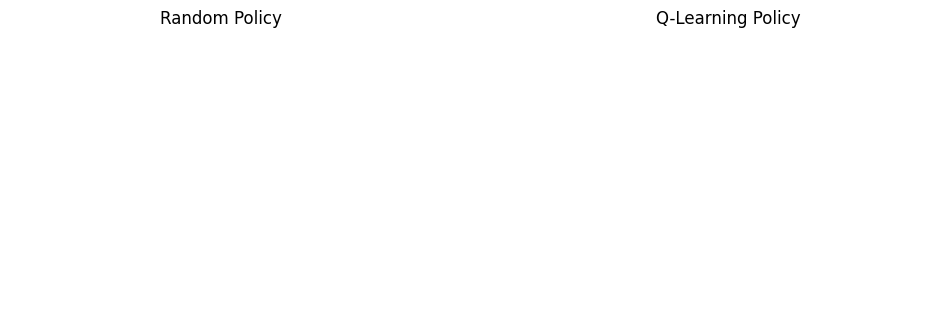

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import display
from tqdm import trange

rc('animation', html='jshtml')

# Create the MountainCar-v0 environment with RGB rendering enabled for visualization
env = gym.make("MountainCar-v0", render_mode="rgb_array")

# Set the random seed for reproducibility (NumPy random)
np.random.seed(0)

# Reset the environment and fix its seed as well
env.reset(seed=0)

######### Discretization setup ###########

# Define the number of discrete bins for each dimension: [position, velocity]
bins = [20, 20]

# Function to discretize a continuous observation into a discrete state
def discretize(obs, bins):
    # Define upper bounds of the state space
    upper_bounds = np.array([0.6, 0.07])
    # Define lower bounds of the state space
    lower_bounds = np.array([-1.2, -0.07])
    # Normalize observation within [0, 1] based on bounds
    ratios = (obs - lower_bounds) / (upper_bounds - lower_bounds)
    # Scale and round ratios to match the bin indices
    discrete_obs = np.round((np.array(bins) - 1) * ratios).astype(int)
    # Ensure indices are within valid range
    discrete_obs = np.clip(discrete_obs, 0, np.array(bins) - 1)
    return tuple(discrete_obs)

####### Q-learning training function #######

def train_q_learning(env, bins, num_episodes=5000, learning_rate=0.1,
                     discount_factor=0.99, epsilon=1.0, epsilon_decay=0.999,
                     epsilon_min=0.05):

    # Initialize the Q-table with zeros: shape = (bins[0], bins[1], num_actions)
    q_table = np.zeros(bins + [env.action_space.n])

    # Store total rewards per episode
    rewards_per_episode = []

    # Loop over episodes
    for episode in trange(num_episodes):
        # Reset the environment and get the initial observation
        obs, _ = env.reset()
        # Convert observation to discrete state
        discrete_state = discretize(obs, bins)
        done = False
        total_reward = 0

        # Loop until the episode terminates
        while not done:
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # explore
            else:
                action = np.argmax(q_table[discrete_state])  # exploit

            # Apply action and get feedback from environment
            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_discrete_state = discretize(next_obs, bins)

            # Q-learning update
            best_future_q = np.max(q_table[next_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            q_table[discrete_state + (action,)] += learning_rate * (
                reward + discount_factor * best_future_q - current_q
            )

            # Move to next state
            discrete_state = next_discrete_state
            total_reward += reward
            done = terminated or truncated  # episode ends

        # Decay epsilon (exploration rate)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        # Store the reward
        rewards_per_episode.append(total_reward)

        # Print progress every 500 episodes
        if (episode + 1) % 500 == 0:
            avg_r = np.mean(rewards_per_episode[-500:])
            print(f"Episode {episode + 1}: Avg Reward (last 500): {avg_r:.2f}, Epsilon: {epsilon:.3f}")

    return q_table, rewards_per_episode

###################### Train the agent #######################

# Train the agent and get the learned Q-table and rewards
q_table, rewards = train_q_learning(env, bins)

############## Define policies for comparison #################

# Random policy: returns a random action (for baseline comparison)
def random_policy(_):
    return env.action_space.sample()

# Trained policy: selects the best action from the Q-table
def trained_policy(discrete_state):
    return np.argmax(q_table[discrete_state])

####### Capture frames from an episode using a policy #########

def capture_episode_frames(policy_fn):
    frames = []
    obs, _ = env.reset()
    discrete_state = discretize(obs, bins)
    done = False

    # Simulate episode until termination
    while not done:
        action = policy_fn(discrete_state)
        next_obs, reward, terminated, truncated, _ = env.step(action)

        # Render current frame (RGB array)
        frame = env.render()
        frames.append(frame)

        # Update state
        discrete_state = discretize(next_obs, bins)
        done = terminated or truncated

    return frames

########## Record visual rollouts for comparison ##############

# Capture episode using the random policy
frames_random = capture_episode_frames(random_policy)

# Capture episode using the trained Q-learning policy
frames_trained = capture_episode_frames(trained_policy)

######### Plot side-by-side animations of both policies ########

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("Random Policy")
ax2.set_title("Q-Learning Policy")
ax1.axis('off')
ax2.axis('off')

# Collect and store frame pairs for animation
ims = []
min_len = min(len(frames_random), len(frames_trained))
for i in range(min_len):
    im1 = ax1.imshow(frames_random[i], animated=True)
    im2 = ax2.imshow(frames_trained[i], animated=True)
    ims.append([im1, im2])

# Create and display animation
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
display(ani)
